In [1]:

from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 10: EDA Reporting (Narratives, Assumptions, and Actionable Insights)

### What this notebook teaches

Most EDA notebooks look like an analyst’s scratchpad: dozens of plots, many half-finished ideas, and little decision support.

An EDA **report** is different. It is a decision artifact. It answers:

- **What is true in the data (evidence)?**
- **What might it mean (interpretation + uncertainty)?**
- **What should we do next (actions + validation)?**

In this lesson you will practice the “reporting layer” of EDA:
- writing narratives that are aligned to goals,
- making assumptions explicit (so others can challenge or validate them),
- and producing actionable insights (with owners and verification plans).

### Learning outcomes

After completing this notebook, you should be able to:

1. Create a structured EDA report (executive summary → data overview → key findings → risks/assumptions → next steps).
2. Convert EDA charts/tables into narrative bullets that a stakeholder can act on.
3. Distinguish: **observation** (measured) vs **hypothesis** (explanation) vs **recommendation** (next action).
4. Communicate uncertainty using both qualitative language and simple quantitative intervals.
5. Build a small, reusable Python “report generator” for tabular datasets.

### Datasets used

We will intentionally use two different dataset types (to practice reporting across contexts):

- **NYC_Collisions**: event-level records with timestamps, location, outcomes (injuries/fatalities).
- **Fast_Food_Restaurants_US**: entity-level records with text categories and geolocation.

Paths:
- `../../../Datasets/Regression/NYC_Collisions.csv`
- `../../../Datasets/Classification/Fast_Food_Restaurants_US.csv`

---

## 0) The EDA reporting contract

Before you write anything, define your reporting contract:

### Audience (who will read this?)
- Executives: want 5–10 bullets + risks + decision asks.
- Product/ops: want “where/when/why” + actions.
- Data science: wants enough detail to trust results and reproduce.

### Objective (what decision does this support?)
Examples:
- “Prioritize interventions to reduce injury risk.”
- “Assess whether a location dataset is clean enough for downstream analytics.”

### Scope (what is included/excluded?)
Be explicit about:
- time range,
- filters,
- sampling (if any),
- and known blind spots (fields missing, limited coverage).

### Evidence standard
A good rule: every important claim must have at least one supporting artifact:
- a table,
- a chart,
- or a reproducible metric.

If you cannot support a claim with data, label it as a **hypothesis** and propose verification.

---

## 1) A writing model you can reuse: Observation → Implication → Recommendation

A “finding” in an EDA report should typically follow:

1. **Observation:** what the data shows (quantified)
2. **Implication:** why it matters to the objective
3. **Recommendation:** what action to take next (and how to validate)

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 180)

DATASET_COLLISIONS = r"../../../Datasets/Regression/NYC_Collisions.csv"
DATASET_FASTFOOD = r"../../../Datasets/Classification/Fast_Food_Restaurants_US.csv"

def read_csv_strict(path, nrows=None):
    # In this repository, CSVs should exist at the given relative paths.
    return pd.read_csv(path, nrows=nrows, low_memory=False)

def pct(x):
    return 100.0 * x

def summarize_missing(df):
    m = df.isna().mean().sort_values(ascending=False)
    out = pd.DataFrame({"missing_rate": m, "missing_pct": pct(m)})
    return out[out["missing_rate"] > 0]

def df_overview(df, name="dataset"):
    return pd.DataFrame({
        "dataset": [name],
        "rows": [len(df)],
        "cols": [df.shape[1]],
        "memory_mb": [df.memory_usage(deep=True).sum() / (1024**2)],
        "duplicate_rows": [int(df.duplicated().sum())],
    })

def parse_datetime(date_series, time_series=None):
    if time_series is None:
        return pd.to_datetime(date_series, errors="coerce")
    return pd.to_datetime(date_series.astype(str) + " " + time_series.astype(str), errors="coerce")

## 2) Load data and set a reporting scope

For large CSVs, exploration is often iterative:

1. Load a working sample to stabilize logic and visuals.
2. Validate results on a larger slice (or full data) once the report stabilizes.

Here we use a row limit to keep the notebook responsive.

In [3]:

NROWS_COLLISIONS = 200_000
NROWS_FASTFOOD = 200_000

coll = read_csv_strict(DATASET_COLLISIONS, nrows=NROWS_COLLISIONS)
ff = read_csv_strict(DATASET_FASTFOOD, nrows=NROWS_FASTFOOD)

pd.concat([df_overview(coll, "NYC_Collisions"), df_overview(ff, "Fast_Food_Restaurants_US")], ignore_index=True)

,dataset,rows,cols,memory_mb,duplicate_rows
0,NYC_Collisions,125445,20,64.418501,0
1,Fast_Food_Restaurants_US,10000,11,5.729819,0


In [4]:
coll.head()

,COLLISION_ID,ACCIDENT_DATE,ACCIDENT_TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,STREET NAME,CROSS STREET NAME,FULL ADDRESS,VEHICLE TYPE,CONTRIBUTING FACTOR,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLIST INJURED,CYCLIST KILLED,MOTORIST INJURED,MOTORIST KILLED
0,4380785,2021-01-01,00:00:00,QUEENS,11434.0,40.664536,-73.77314,NaN,NaN,145-8 175 STREET,Station Wagon/Sport Utility Vehicle,Unspecified,0.0,0,0,0,0,0,0,0
1,4380974,2021-01-01,00:00:00,QUEENS,11355.0,40.754375,-73.82340,BEECH AVENUE,KISSENA BOULEVARD,NaN,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
2,4381080,2021-01-01,00:00:00,BROOKLYN,11203.0,40.658295,-73.93109,UTICA AVENUE,WINTHROP STREET,NaN,Station Wagon/Sport Utility Vehicle,Driver Inattention/Distraction,1.0,0,0,0,0,0,1,0
3,4381095,2021-01-01,00:00:00,BROOKLYN,11212.0,40.661873,-73.92878,NaN,NaN,108 EAST 91 STREET,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
4,4381962,2021-01-01,00:00:00,NaN,NaN,40.834198,-73.85169,WESTCHESTER AVENUE,NaN,NaN,Sedan,Unspecified,1.0,0,1,0,0,0,0,0


In [5]:
ff.head()

,Unnamed: 0,address,categories,city,country,latitude,longitude,name,postalCode,province,websites
0,0,800 N Canal Blvd,American Restaurant and Fast Food Restaurant,Thibodaux,US,29.814697,-90.814742,SONIC Drive In,70301,LA,https://locations.sonicdrivein.com/la/thibodau...
1,1,800 N Canal Blvd,Fast Food Restaurants,Thibodaux,US,29.814697,-90.814742,SONIC Drive In,70301,LA,https://locations.sonicdrivein.com/la/thibodau...
2,2,206 Wears Valley Rd,Fast Food Restaurant,Pigeon Forge,US,35.803788,-83.580553,Taco Bell,37863,TN,"http://www.tacobell.com,https://locations.taco..."
3,3,3652 Parkway,Fast Food,Pigeon Forge,US,35.782339,-83.551408,Arby's,37863,TN,"http://www.arbys.com,https://locations.arbys.c..."
4,4,2118 Mt Zion Parkway,Fast Food Restaurant,Morrow,US,33.562738,-84.321143,Steak 'n Shake,30260,GA,http://www.steaknshake.com/locations/23851-ste...


## 3) Data overview: schema + missingness + duplicates

Your data overview should include:
- key fields and dtypes,
- top missing columns,
- duplicates (row-level and entity-level risk).

In [6]:

schema_coll = coll.dtypes.astype(str).to_frame("dtype")
schema_ff = ff.dtypes.astype(str).to_frame("dtype")
schema_coll.head(25), schema_ff.head(25)

(                       dtype
 COLLISION_ID           int64
 ACCIDENT_DATE         object
 ACCIDENT_TIME         object
 BOROUGH               object
 ZIP CODE             float64
 LATITUDE             float64
 LONGITUDE            float64
 STREET NAME           object
 CROSS STREET NAME     object
 FULL ADDRESS          object
 VEHICLE TYPE          object
 CONTRIBUTING FACTOR   object
 PERSONS INJURED      float64
 PERSONS KILLED         int64
 PEDESTRIANS INJURED    int64
 PEDESTRIANS KILLED     int64
 CYCLIST INJURED        int64
 CYCLIST KILLED         int64
 MOTORIST INJURED       int64
 MOTORIST KILLED        int64,
               dtype
 Unnamed: 0    int64
 address      object
 categories   object
 city         object
 country      object
 latitude    float64
 longitude   float64
 name         object
 postalCode   object
 province     object
 websites     object)

In [7]:

missing_coll = summarize_missing(coll).head(15)
missing_ff = summarize_missing(ff).head(15)
missing_coll, missing_ff

(                     missing_rate  missing_pct
 FULL ADDRESS             0.730623    73.062298
 CROSS STREET NAME        0.536833    53.683287
 ZIP CODE                 0.345578    34.557774
 BOROUGH                  0.345466    34.546614
 STREET NAME              0.269385    26.938499
 LONGITUDE                0.088804     8.880386
 LATITUDE                 0.088804     8.880386
 VEHICLE TYPE             0.012141     1.214078
 CONTRIBUTING FACTOR      0.005030     0.503009
 PERSONS INJURED          0.000008     0.000797,
 Empty DataFrame
 Columns: [missing_rate, missing_pct]
 Index: [])

In [8]:

quality_summary = pd.DataFrame({
    "metric": [
        "collisions_missing_borough_pct",
        "collisions_missing_zip_pct",
        "collisions_duplicate_rows",
        "fastfood_duplicate_rows",
        "fastfood_missing_name_pct",
        "fastfood_missing_lat_pct",
        "fastfood_missing_lon_pct",
    ],
    "value": [
        float(pct(coll["BOROUGH"].isna().mean())) if "BOROUGH" in coll.columns else np.nan,
        float(pct(coll["ZIP CODE"].isna().mean())) if "ZIP CODE" in coll.columns else np.nan,
        int(coll.duplicated().sum()),
        int(ff.duplicated().sum()),
        float(pct(ff["name"].isna().mean())) if "name" in ff.columns else np.nan,
        float(pct(ff["latitude"].isna().mean())) if "latitude" in ff.columns else np.nan,
        float(pct(ff["longitude"].isna().mean())) if "longitude" in ff.columns else np.nan,
    ]
})
quality_summary

,metric,value
0,collisions_missing_borough_pct,34.546614
1,collisions_missing_zip_pct,34.557774
2,collisions_duplicate_rows,0.000000
3,fastfood_duplicate_rows,0.000000
4,fastfood_missing_name_pct,0.000000
5,fastfood_missing_lat_pct,0.000000
6,fastfood_missing_lon_pct,0.000000


### Converting quality metrics into report language

Bad (analyst-only):
- “BOROUGH missingness = 18%.”

Good (report-ready):
- “`BOROUGH` is missing in 18% of records; borough comparisons may be biased if missingness is systematic. We will include ‘Unknown’ as a separate group and analyze missingness patterns over time.”

## 4) Worked example A: EDA reporting for NYC collisions

Stakeholder question (example):

> “Where and when do collisions with injuries concentrate, and what factors appear most common?”

In [9]:

# Parse datetime and derive time features
if {"ACCIDENT_DATE", "ACCIDENT_TIME"}.issubset(coll.columns):
    coll["accident_dt"] = parse_datetime(coll["ACCIDENT_DATE"], coll["ACCIDENT_TIME"])
elif "ACCIDENT_DATE" in coll.columns:
    coll["accident_dt"] = parse_datetime(coll["ACCIDENT_DATE"])
else:
    coll["accident_dt"] = pd.NaT

coll["accident_month"] = coll["accident_dt"].dt.to_period("M").astype(str)
coll["accident_dow"] = coll["accident_dt"].dt.day_name()
coll["accident_hour"] = coll["accident_dt"].dt.hour

inj = "PERSONS INJURED"
killed = "PERSONS KILLED"
for c in [inj, killed]:
    if c in coll.columns:
        coll[c] = pd.to_numeric(coll[c], errors="coerce")

coll[[ "accident_dt", "accident_month", "accident_dow", "accident_hour", inj, killed ]].head()

,accident_dt,accident_month,accident_dow,accident_hour,PERSONS INJURED,PERSONS KILLED
0,2021-01-01,2021-01,Friday,0,0.0,0
1,2021-01-01,2021-01,Friday,0,0.0,0
2,2021-01-01,2021-01,Friday,0,1.0,0
3,2021-01-01,2021-01,Friday,0,0.0,0
4,2021-01-01,2021-01,Friday,0,1.0,0


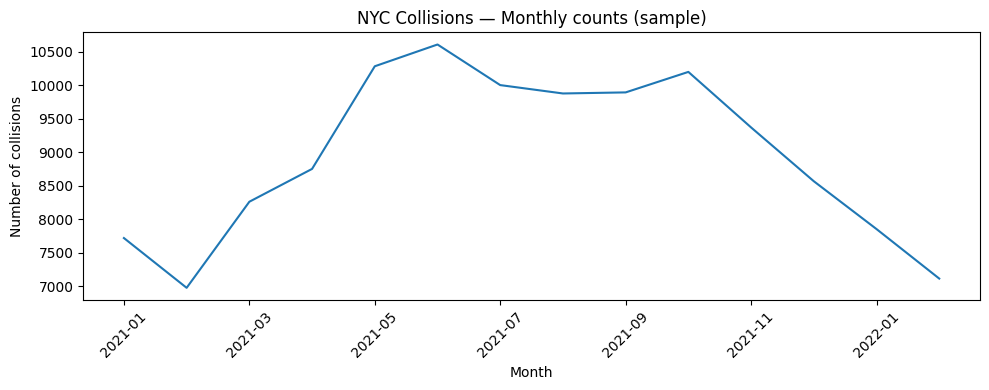

accident_month
2021-03     8259
2021-04     8749
2021-05    10281
2021-06    10606
2021-07    10000
2021-08     9875
2021-09     9891
2021-10    10197
2021-11     9368
2021-12     8565
2022-01     7851
2022-02     7112
dtype: int64

In [10]:

# Monthly collision volume (sample)
month_counts = coll.dropna(subset=["accident_dt"]).groupby("accident_month").size().sort_index()

plt.figure(figsize=(10, 4))
month_counts.plot()
plt.title("NYC Collisions — Monthly counts (sample)")
plt.xlabel("Month")
plt.ylabel("Number of collisions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

month_counts.tail(12)

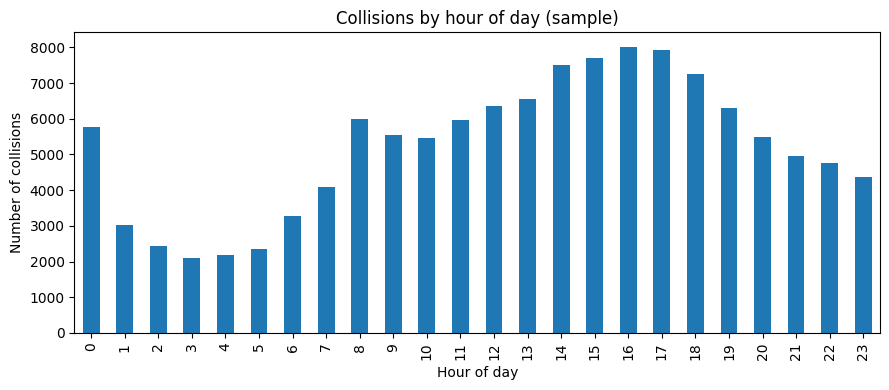

accident_hour
0    5779
1    3033
2    2441
3    2099
4    2197
Name: count, dtype: int64

In [11]:

# Hour-of-day pattern (sample)
hour_counts = coll["accident_hour"].value_counts(dropna=True).sort_index()

plt.figure(figsize=(9, 4))
hour_counts.plot(kind="bar")
plt.title("Collisions by hour of day (sample)")
plt.xlabel("Hour of day")
plt.ylabel("Number of collisions")
plt.tight_layout()
plt.show()

hour_counts.head()

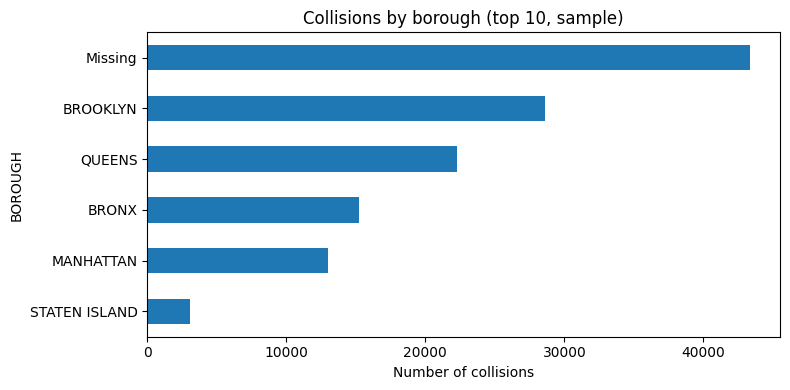

In [12]:

# Borough distribution (if available)
if "BOROUGH" in coll.columns:
    borough_counts = coll["BOROUGH"].fillna("Missing").value_counts()
    plt.figure(figsize=(8, 4))
    borough_counts.head(10).sort_values().plot(kind="barh")
    plt.title("Collisions by borough (top 10, sample)")
    plt.xlabel("Number of collisions")
    plt.tight_layout()
    plt.show()
    borough_counts.head(10)
else:
    "Column BOROUGH not found."

In [13]:

# Severity summary
sev_cols = [c for c in [inj, killed] if c in coll.columns]
coll[sev_cols].describe(percentiles=[0.5, 0.9, 0.99]) if sev_cols else "Severity columns not found."

,PERSONS INJURED,PERSONS KILLED
count,125444.000000,125445.000000
mean,0.463617,0.002655
std,0.787200,0.053430
min,0.000000,0.000000
50%,0.000000,0.000000
90%,1.000000,0.000000
99%,3.000000,0.000000
max,18.000000,3.000000


In [14]:

# Injury involvement by borough (illustrative)
if "BOROUGH" in coll.columns and inj in coll.columns:
    tmp = coll.copy()
    tmp["has_injury"] = (tmp[inj].fillna(0) >= 1).astype(int)
    injury_by_borough = tmp.groupby(tmp["BOROUGH"].fillna("Missing"))["has_injury"].mean().sort_values(ascending=False)
    injury_by_borough.head(10).to_frame("injury_rate").assign(injury_rate_pct=lambda d: pct(d["injury_rate"]))
else:
    "Required columns not found."

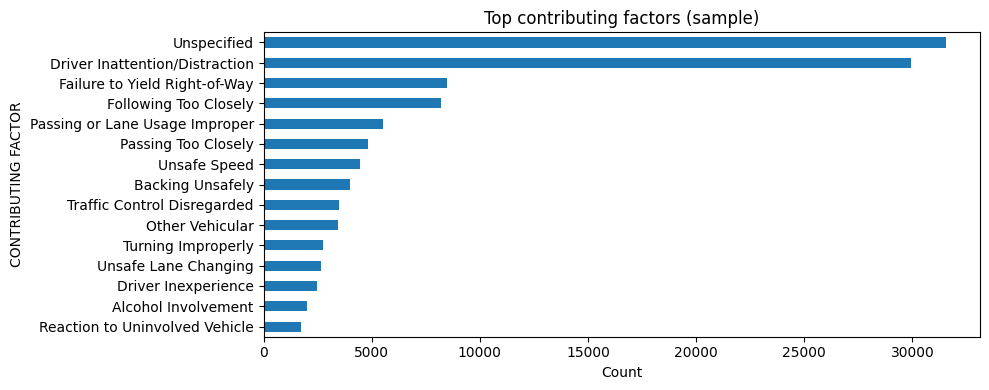

In [15]:

# Contributing factors (if present)
factor_col = "CONTRIBUTING FACTOR"
if factor_col in coll.columns:
    top_factors = coll[factor_col].fillna("Missing").value_counts().head(15)
    plt.figure(figsize=(10, 4))
    top_factors.sort_values().plot(kind="barh")
    plt.title("Top contributing factors (sample)")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()
    top_factors
else:
    "Contributing factor column not found."

### Report-ready findings (example text you should edit)

Use the outputs above to fill in the numbers and refine the language.

**Finding A1 — Time-of-day concentration**
- Observation: Collision volume peaks at specific hours (see chart).
- Implication: Time-bound interventions may yield disproportionate benefit during peak windows.
- Recommendation: Build an injury-weighted hourly profile and prioritize the top hours; validate via pre/post analysis.

**Finding A2 — Geography missingness (risk)**
- Observation: Borough/ZIP fields have missingness (see missingness table).
- Implication: Geographic comparisons may be biased if missingness is systematic.
- Recommendation: Analyze missingness mechanisms; include “Unknown” group in borough charts.

**Finding A3 — Severity is heavy-tailed**
- Observation: Injuries show a long tail (compare median vs P99).
- Implication: Mean-based summaries can understate rare high-impact events.
- Recommendation: Report tail metrics and severity buckets (0, 1, 2–3, 4+).

## 5) Uncertainty and confidence statements

A simple quantitative illustration is a confidence interval for a mean:

$$
\bar{x} \pm z_{1-\alpha/2}\frac{s}{\sqrt{n}}
$$

Below we compute an approximate 95% interval for mean injuries per collision.

In [16]:

if inj in coll.columns:
    x = coll[inj].fillna(0).to_numpy()
    n = len(x)
    mean = float(x.mean())
    std = float(x.std(ddof=1))
    z = 1.96
    half = z * std / np.sqrt(n)
    pd.DataFrame({"metric": ["mean_injuries", "ci_low", "ci_high", "n"], "value": [mean, mean-half, mean+half, n]})
else:
    "Injury column not found."

## 6) Worked example B: EDA reporting for entity/location data (fast food)

Stakeholder question (example):

> “Can we create a clean, canonical location table for downstream analytics?”

In [17]:

ff_overview = df_overview(ff, "Fast_Food_Restaurants_US")
ff_missing = summarize_missing(ff).head(20)
ff_overview, ff_missing

(                    dataset   rows  cols  memory_mb  duplicate_rows
 0  Fast_Food_Restaurants_US  10000    11   5.730083               0,
 Empty DataFrame
 Columns: [missing_rate, missing_pct]
 Index: [])

In [18]:

top_names = ff["name"].fillna("Missing").value_counts().head(10) if "name" in ff.columns else None
top_cats = ff["categories"].fillna("Missing").value_counts().head(10) if "categories" in ff.columns else None
top_names, top_cats

(name
 McDonald's         1898
 Taco Bell          1032
 Burger King         833
 Subway              776
 Arby's              663
 Wendy's             628
 Jack in the Box     330
 Pizza Hut           230
 Dairy Queen         218
 Domino's Pizza      215
 Name: count, dtype: int64,
 categories
 Fast Food Restaurant                                             3425
 Fast Food Restaurants                                            3406
 Fast Food                                                        1777
 Fast Food Restaurant and Burger Joint                             260
 Fast food restaurants                                             191
 Fast Food Restaurant and Mexican Restaurant                       132
 Fast Food Restaurant, American Restaurant, and Sandwich Place     101
 Fast Food Restaurant, Sandwich Place, and American Restaurant      65
 Sandwich Place and Fast Food Restaurant                            35
 Fast Food Restaurant and American Restaurant                    

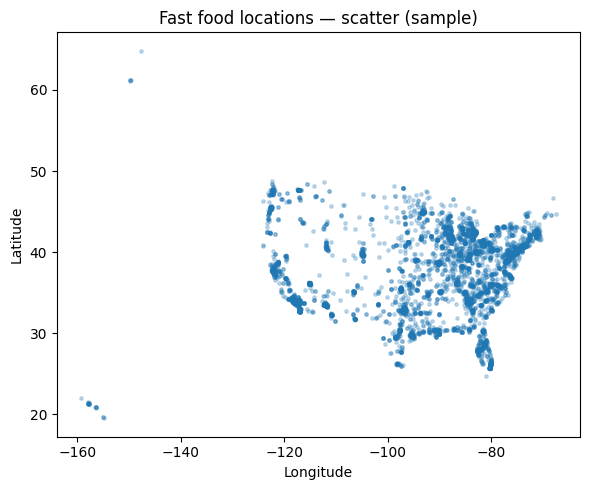

In [19]:

# Quick geospatial scatter
if {"latitude", "longitude"}.issubset(ff.columns):
    geo = ff[["latitude","longitude"]].dropna()
    sample = geo.sample(min(5000, len(geo)), random_state=42)
    plt.figure(figsize=(6, 5))
    plt.scatter(sample["longitude"], sample["latitude"], s=6, alpha=0.25)
    plt.title("Fast food locations — scatter (sample)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()
else:
    "Latitude/longitude columns not found."

In [20]:

# Heuristic duplicate detection: normalized name + rounded coordinates
if {"name","latitude","longitude"}.issubset(ff.columns):
    ff_key = ff.assign(
        name_n=ff["name"].astype(str).str.strip().str.lower(),
        lat_r=ff["latitude"].round(5),
        lon_r=ff["longitude"].round(5),
    ).dropna(subset=["lat_r","lon_r"])
    dup_counts = ff_key.groupby(["name_n","lat_r","lon_r"]).size().sort_values(ascending=False)
    dup_counts.head(15)
else:
    "Required columns not found."

### Practical example: normalizing a multi-URL field

We split a comma-separated URL field, remove empties, and drop common tracking parameters.

In [21]:

import urllib.parse as ul

def normalize_url(u: str) -> str:
    if not isinstance(u, str):
        return ""
    u = u.strip()
    if not u:
        return ""
    parsed = ul.urlsplit(u)
    q = ul.parse_qsl(parsed.query, keep_blank_values=True)
    q = [(k, v) for (k, v) in q if not k.lower().startswith("utm_")]
    new_query = ul.urlencode(q)
    parsed2 = parsed._replace(query=new_query)
    return ul.urlunsplit(parsed2)

def split_and_normalize_urls(field: str):
    if not isinstance(field, str):
        return []
    parts = [p.strip() for p in field.split(",")]
    parts = [p for p in parts if p]
    return [normalize_url(p) for p in parts]

if "websites" in ff.columns:
    example = ff["websites"].dropna().iloc[0]
    example, split_and_normalize_urls(example)[:5]
else:
    "Column websites not found."

### Practical example: taxonomy mapping for free-text categories

We define a small controlled vocabulary (taxonomy) and map raw category strings into standardized tags.

In [22]:

TAXONOMY = {
    "burger": ["burger", "hamburger"],
    "pizza": ["pizza"],
    "mexican": ["taco", "mexican", "burrito"],
    "coffee": ["coffee", "cafe"],
    "chicken": ["chicken", "fried chicken"],
    "ice_cream": ["ice cream", "dessert", "shake"],
}

def map_category(raw: str):
    if not isinstance(raw, str):
        return []
    s = raw.lower()
    tags = []
    for tag, keywords in TAXONOMY.items():
        if any(k in s for k in keywords):
            tags.append(tag)
    return tags

if "categories" in ff.columns:
    mapped = ff["categories"].fillna("").apply(map_category)
    coverage = (mapped.apply(len) > 0).mean()
    coverage, pct(coverage)
else:
    "Column categories not found."

In [23]:

if "categories" in ff.columns:
    tag_counts = mapped.explode().value_counts().dropna()
    tag_counts.to_frame("count")
else:
    "No category mapping computed."

## 7) Executive summary blocks (generated)

Programmatically generating executive summaries reduces accidental omissions and makes reports consistent.

In [24]:
from IPython.display import Markdown, display

def md_bullets_from_series(s, label, n=5):
    lines = [f"- **{label}:**"]
    for k, v in s.head(n).items():
        try:
            v_int = int(v)
            lines.append(f"  - {k}: {v_int:,}")
        except Exception:
            lines.append(f"  - {k}: {v}")
    return "\n".join(lines)

def collisions_headlines(df):
    h = {"rows": len(df)}

    if "accident_dt" in df.columns and df["accident_dt"].notna().any():
        h["date_min"] = str(df["accident_dt"].min())
        h["date_max"] = str(df["accident_dt"].max())

    if "BOROUGH" in df.columns:
        h["borough_missing_pct"] = float(df["BOROUGH"].isna().mean() * 100.0)
        h["top_boroughs"] = df["BOROUGH"].fillna("Missing").value_counts().head(5)

    if "CONTRIBUTING FACTOR" in df.columns:
        h["top_factors"] = df["CONTRIBUTING FACTOR"].fillna("Missing").value_counts().head(5)

    if "PERSONS INJURED" in df.columns:
        injured = df["PERSONS INJURED"].fillna(0)
        h["injury_involvement_pct"] = float((injured >= 1).mean() * 100.0)
        h["injured_p99"] = float(injured.quantile(0.99))

    return h

def render_collisions_exec_summary(df):
    h = collisions_headlines(df)

    bullets = []
    bullets.append(f"- **Rows:** {h['rows']:,}")

    if "date_min" in h and "date_max" in h:
        bullets.append(f"- **Date range:** {h['date_min']} → {h['date_max']}")

    if "injury_involvement_pct" in h:
        bullets.append(f"- **Injury involvement:** {h['injury_involvement_pct']:.2f}% of records have ≥1 injured.")
    if "injured_p99" in h:
        bullets.append(f"- **Tail (P99) of injuries:** {h['injured_p99']:.0f}")

    if "borough_missing_pct" in h:
        bullets.append(f"- **Key risk:** missing `BOROUGH` = {h['borough_missing_pct']:.2f}%.")

    if "top_boroughs" in h:
        bullets.append(md_bullets_from_series(h["top_boroughs"], "Top boroughs by volume"))

    if "top_factors" in h:
        bullets.append(md_bullets_from_series(h["top_factors"], "Top contributing factors"))

    bullets.append("- **Next steps:**")
    bullets.append("  - Analyze location missingness; include an 'Unknown' group in borough reporting.")
    bullets.append("  - Report severity using tail metrics and severity buckets.")
    bullets.append("  - If risk rates are needed, join to exposure denominators (traffic volume/population).")

    display(Markdown("# Executive Summary — NYC Collisions (sample)\n\n" + "\n".join(bullets)))

render_collisions_exec_summary(coll)


# Executive Summary — NYC Collisions (sample)

- **Rows:** 125,445
- **Date range:** 2021-01-01 00:00:00 → 2022-02-28 23:37:00
- **Injury involvement:** 34.63% of records have ≥1 injured.
- **Tail (P99) of injuries:** 3
- **Key risk:** missing `BOROUGH` = 34.55%.
- **Top boroughs by volume:**
  - Missing: 43,337
  - BROOKLYN: 28,573
  - QUEENS: 22,267
  - BRONX: 15,211
  - MANHATTAN: 13,002
- **Top contributing factors:**
  - Unspecified: 31,550
  - Driver Inattention/Distraction: 29,923
  - Failure to Yield Right-of-Way: 8,503
  - Following Too Closely: 8,214
  - Passing or Lane Usage Improper: 5,533
- **Next steps:**
  - Analyze location missingness; include an 'Unknown' group in borough reporting.
  - Report severity using tail metrics and severity buckets.
  - If risk rates are needed, join to exposure denominators (traffic volume/population).

In [25]:
from IPython.display import Markdown, display

def md_bullets_from_series(s, label, n=5):
    lines = [f"- **{label}:**"]
    for k, v in s.head(n).items():
        try:
            v_int = int(v)
            lines.append(f"  - {k}: {v_int:,}")
        except Exception:
            lines.append(f"  - {k}: {v}")
    return "\n".join(lines)

def fastfood_headlines(df):
    h = {"rows": len(df)}
    h["duplicate_rows"] = int(df.duplicated().sum())

    if "name" in df.columns:
        h["missing_name_pct"] = float(df["name"].isna().mean() * 100.0)
        h["top_names"] = df["name"].fillna("Missing").value_counts().head(5)

    if "categories" in df.columns:
        h["top_category_strings"] = df["categories"].fillna("Missing").value_counts().head(5)

    if {"latitude", "longitude"}.issubset(df.columns):
        h["geo_complete_pct"] = float((~df[["latitude", "longitude"]].isna().any(axis=1)).mean() * 100.0)

    if "websites" in df.columns:
        h["missing_websites_pct"] = float(df["websites"].isna().mean() * 100.0)

    return h

def render_fastfood_exec_summary(df):
    h = fastfood_headlines(df)

    bullets = []
    bullets.append(f"- **Rows:** {h['rows']:,}")
    bullets.append(f"- **Duplicate rows:** {h['duplicate_rows']:,}")

    if "geo_complete_pct" in h:
        bullets.append(f"- **Geo complete:** {h['geo_complete_pct']:.2f}% have both latitude and longitude.")
    if "missing_name_pct" in h:
        bullets.append(f"- **Missing `name`:** {h['missing_name_pct']:.2f}%.")

    if "missing_websites_pct" in h:
        bullets.append(f"- **Missing `websites`:** {h['missing_websites_pct']:.2f}%.")

    if "top_names" in h:
        bullets.append(md_bullets_from_series(h["top_names"], "Top restaurant names (raw)"))
    if "top_category_strings" in h:
        bullets.append(md_bullets_from_series(h["top_category_strings"], "Top category strings (raw)"))

    bullets.append("- **Next steps:**")
    bullets.append("  - Define a canonical entity key and deduplicate using name normalization + spatial clustering.")
    bullets.append("  - Standardize categories using a controlled taxonomy and monitor drift.")
    bullets.append("  - Normalize websites into a clean list of URLs.")

    display(Markdown("# Executive Summary — Fast Food Restaurants (sample)\n\n" + "\n".join(bullets)))

render_fastfood_exec_summary(ff)


# Executive Summary — Fast Food Restaurants (sample)

- **Rows:** 10,000
- **Duplicate rows:** 0
- **Geo complete:** 100.00% have both latitude and longitude.
- **Missing `name`:** 0.00%.
- **Missing `websites`:** 0.00%.
- **Top restaurant names (raw):**
  - McDonald's: 1,898
  - Taco Bell: 1,032
  - Burger King: 833
  - Subway: 776
  - Arby's: 663
- **Top category strings (raw):**
  - Fast Food Restaurant: 3,425
  - Fast Food Restaurants: 3,406
  - Fast Food: 1,777
  - Fast Food Restaurant and Burger Joint: 260
  - Fast food restaurants: 191
- **Next steps:**
  - Define a canonical entity key and deduplicate using name normalization + spatial clustering.
  - Standardize categories using a controlled taxonomy and monitor drift.
  - Normalize websites into a clean list of URLs.

## 8) Actionable insights as deliverables

Action items should include: an owner, expected impact, and a verification plan.

In [26]:

actions = pd.DataFrame([
    {
        "Action": "Investigate BOROUGH/ZIP missingness patterns; define reporting policy for unknown geography.",
        "Owner": "Analytics / Data Engineering",
        "Expected impact": "Reduce bias risk; improve interpretability of borough-level insights.",
        "Validation": "Missingness by time and by location proxies; sensitivity with/without unknown group."
    },
    {
        "Action": "Create injury severity buckets and track tail metrics (P90/P99) monthly.",
        "Owner": "Analytics",
        "Expected impact": "Better prioritization for high-severity risk windows.",
        "Validation": "Backtest stability and variance across months; monitor changes after interventions."
    },
    {
        "Action": "Deduplicate restaurant entities with spatial clustering + string normalization; publish canonical entity table.",
        "Owner": "Data Engineering",
        "Expected impact": "Prevent inflated counts and incorrect coverage estimates.",
        "Validation": "Manual audit of sampled clusters; measure false merges and missed duplicates."
    },
    {
        "Action": "Standardize restaurant categories using a controlled taxonomy + versioned mapping.",
        "Owner": "Data Engineering + Domain",
        "Expected impact": "Stable category analytics and comparable trends over time.",
        "Validation": "Coverage, drift monitoring, and periodic mapping review."
    },
])
actions

,Action,Owner,Expected impact,Validation
0,Investigate BOROUGH/ZIP missingness patterns; ...,Analytics / Data Engineering,Reduce bias risk; improve interpretability of ...,Missingness by time and by location proxies; s...
1,Create injury severity buckets and track tail ...,Analytics,Better prioritization for high-severity risk w...,Backtest stability and variance across months;...
2,Deduplicate restaurant entities with spatial c...,Data Engineering,Prevent inflated counts and incorrect coverage...,Manual audit of sampled clusters; measure fals...
3,Standardize restaurant categories using a cont...,Data Engineering + Domain,Stable category analytics and comparable trend...,"Coverage, drift monitoring, and periodic mappi..."


## 9) Assumptions and limitations (testable statements)

Write assumptions so reviewers can respond with: supported / unclear / violated.

When assumptions are unclear, propose a verification step.

In [27]:

assumptions = pd.DataFrame([
    {"Dataset": "NYC Collisions", "Assumption": "ACCIDENT_DATE/ACCIDENT_TIME reflect local time consistently.", "Status": "Unclear", "Verification": "Check anomalies by hour/borough; look for DST artifacts."},
    {"Dataset": "NYC Collisions", "Assumption": "BOROUGH/ZIP missingness is not systematically biased.", "Status": "Unclear", "Verification": "Missingness by time and by location proxies (LAT/LON)."},
    {"Dataset": "Fast Food", "Assumption": "Rows can be resolved into unique physical locations.", "Status": "Unclear", "Verification": "Spatial clustering + text matching; manual audit of ambiguous clusters."},
    {"Dataset": "Fast Food", "Assumption": "Free-text categories can be mapped to a stable taxonomy.", "Status": "Likely", "Verification": "Build mapping; measure coverage and drift."},
])
assumptions

,Dataset,Assumption,Status,Verification
0,NYC Collisions,ACCIDENT_DATE/ACCIDENT_TIME reflect local time...,Unclear,Check anomalies by hour/borough; look for DST ...
1,NYC Collisions,BOROUGH/ZIP missingness is not systematically ...,Unclear,Missingness by time and by location proxies (L...
2,Fast Food,Rows can be resolved into unique physical loca...,Unclear,Spatial clustering + text matching; manual aud...
3,Fast Food,Free-text categories can be mapped to a stable...,Likely,Build mapping; measure coverage and drift.


## 10) Reporting checklist

- Objective and scope are explicit
- Each key claim is backed by evidence
- Risks (missingness/duplicates/leakage) are discussed
- Each finding includes a recommended next step with validation

## 11) Exercises

1. Write a 5-bullet executive summary for collisions: evidence → implication → action.
2. Create severity buckets (0, 1, 2–3, 4+) and write one report-ready finding.
3. Extend fast-food deduplication: cluster nearby points and resolve canonical entities.
4. Extend taxonomy mapping: add tags, report coverage, list top unmapped category strings.

---

## 12) Turning EDA into a narrative: Claim → Evidence → Qualification → Decision

A report is persuasive only when it makes the logic explicit. A practical pattern is:

1. **Claim:** the core statement you want the reader to believe.
2. **Evidence:** the artifact(s) that justify it (tables, charts, statistics).
3. **Qualification:** uncertainty, caveats, known data quality risks.
4. **Decision/Action:** what the reader should do next, and how success will be measured.

### A compact writing template

Use this as a reusable block in your report:

- **Claim:** ...
- **Evidence:** ...
- **Qualification:** ...
- **Decision ask:** ...

### Anti-patterns to avoid

- “We observed X” without quantification.
- “The data suggests Y” without showing where.
- “This proves Z” when the analysis is correlational.
- Recommendations without owners or validation plans.

### Example (collisions)

- **Claim:** Injury-involving collisions concentrate in predictable time windows.
- **Evidence:** Hour-of-day distribution and injury-rate-by-hour table.
- **Qualification:** The dataset contains missingness in geography fields; exposure denominators (traffic volume) are not included, so counts are not rates per vehicle-mile.
- **Decision ask:** Pilot an intervention for the top hours; evaluate with a controlled pre/post analysis and a severity-weighted metric.

### Example (locations)

- **Claim:** A canonical location table is feasible but requires deduplication and taxonomy mapping.
- **Evidence:** Duplicate key counts (normalized name + rounded coordinates), category coverage from taxonomy mapping.
- **Qualification:** Free-text categories are noisy; mapping is a governance decision and must be versioned.
- **Decision ask:** Create a v1 canonical entity key, publish a reference table, and run a human audit on ambiguous clusters.

---

## 13) Assumptions: how to write them so they can be validated

Assumptions are not “apologies”. They are testable statements that protect your report from misinterpretation.

### Common assumption types

1. **Definition assumptions** (what a field means)
   - Example: “`PERSONS INJURED` counts all injuries, including minor.”
2. **Measurement assumptions** (instrument/recording)
   - Example: time fields are local time and consistently formatted.
3. **Sampling/coverage assumptions**
   - Example: the dataset represents the full population of interest (often false).
4. **Missingness assumptions**
   - Example: missing `BOROUGH` is not systematically related to injury severity.
5. **Aggregation assumptions**
   - Example: monthly grouping is appropriate for the decision horizon.

### A strong assumption statement includes a check

- **Assumption:** ...
- **Why it matters:** ...
- **Verification:** ...
- **Contingency:** what you will do if it fails

In [28]:
# A small helper to turn a register (table) into report-ready Markdown (no extra dependencies)
from IPython.display import Markdown, display

def _escape_md(x):
    s = str(x)
    s = s.replace("\n", " ")
    s = s.replace("|", r"\|")
    return s

def df_to_markdown_str(df, max_rows=20):
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)

    cols = list(d.columns)
    lines = []
    lines.append("| " + " | ".join(map(str, cols)) + " |")
    lines.append("| " + " | ".join(["---"] * len(cols)) + " |")

    for _, row in d.iterrows():
        vals = [_escape_md(v) for v in row.tolist()]
        lines.append("| " + " | ".join(vals) + " |")

    return "\n".join(lines)

def df_to_markdown(df, title=None, max_rows=20):
    md_text = ""
    if title:
        md_text += f"### {title}\n\n"
    md_text += df_to_markdown_str(df, max_rows=max_rows)
    display(Markdown(md_text))

df_to_markdown(assumptions, title="Assumption register (sample)", max_rows=50)


### Assumption register (sample)

| Dataset | Assumption | Status | Verification |
| --- | --- | --- | --- |
| NYC Collisions | ACCIDENT_DATE/ACCIDENT_TIME reflect local time consistently. | Unclear | Check anomalies by hour/borough; look for DST artifacts. |
| NYC Collisions | BOROUGH/ZIP missingness is not systematically biased. | Unclear | Missingness by time and by location proxies (LAT/LON). |
| Fast Food | Rows can be resolved into unique physical locations. | Unclear | Spatial clustering + text matching; manual audit of ambiguous clusters. |
| Fast Food | Free-text categories can be mapped to a stable taxonomy. | Likely | Build mapping; measure coverage and drift. |

---

## 14) Actionability scoring: impact × confidence ÷ effort

Stakeholders often ask: “What should we do first?” You can support prioritization with a lightweight scoring model.

One simple score is:

$$
\text{score} = \frac{\text{impact} \times \text{confidence}}{\text{effort}}
$$

Where each dimension is on a 1–5 scale. This does not replace judgment; it makes tradeoffs explicit.

In [29]:

# Add an action prioritization score
actions_scored = actions.copy()
actions_scored["Impact (1-5)"] = [5, 4, 5, 4][:len(actions_scored)]
actions_scored["Confidence (1-5)"] = [3, 4, 3, 3][:len(actions_scored)]
actions_scored["Effort (1-5)"] = [2, 2, 4, 3][:len(actions_scored)]

actions_scored["PriorityScore"] = (actions_scored["Impact (1-5)"] * actions_scored["Confidence (1-5)"]) / actions_scored["Effort (1-5)"]
actions_scored.sort_values("PriorityScore", ascending=False)

,Action,Owner,Expected impact,Validation,Impact (1-5),Confidence (1-5),Effort (1-5),PriorityScore
1,Create injury severity buckets and track tail ...,Analytics,Better prioritization for high-severity risk w...,Backtest stability and variance across months;...,4,4,2,8.00
0,Investigate BOROUGH/ZIP missingness patterns; ...,Analytics / Data Engineering,Reduce bias risk; improve interpretability of ...,Missingness by time and by location proxies; s...,5,3,2,7.50
3,Standardize restaurant categories using a cont...,Data Engineering + Domain,Stable category analytics and comparable trend...,"Coverage, drift monitoring, and periodic mappi...",4,3,3,4.00
2,Deduplicate restaurant entities with spatial c...,Data Engineering,Prevent inflated counts and incorrect coverage...,Manual audit of sampled clusters; measure fals...,5,3,4,3.75


---

## 15) Deepening the collisions analysis: severity buckets and group comparisons

A reporting-oriented EDA often needs “interpretable buckets” rather than raw counts.

### Severity buckets

A common approach is to define severity buckets based on injuries and fatalities:

- **No harm:** 0 injuries and 0 fatalities
- **Injury:** 1+ injuries and 0 fatalities
- **Fatal:** 1+ fatalities (regardless of injuries)

This is not the only taxonomy; it is a communicable starting point.

In [30]:

# Create severity buckets
def severity_bucket(row):
    inj_v = row.get(inj, np.nan)
    kill_v = row.get(killed, np.nan)
    inj_v = 0 if pd.isna(inj_v) else float(inj_v)
    kill_v = 0 if pd.isna(kill_v) else float(kill_v)

    if kill_v >= 1:
        return "Fatal"
    if inj_v >= 1:
        return "Injury"
    return "No harm"

if inj in coll.columns and killed in coll.columns:
    coll["severity_bucket"] = coll.apply(severity_bucket, axis=1)
    coll["severity_bucket"].value_counts(dropna=False)
else:
    "Severity columns not found."

In [31]:

# Severity over time (monthly)
if "severity_bucket" in coll.columns:
    sev_month = coll.dropna(subset=["accident_month"]).groupby(["accident_month", "severity_bucket"]).size().unstack(fill_value=0).sort_index()
    sev_month.tail(12)
else:
    "Severity bucket not computed."

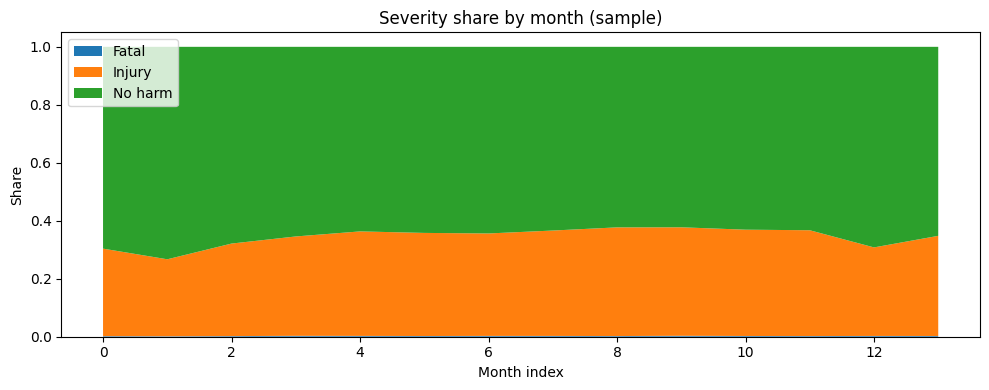

In [32]:

# Visualize severity shares over time (stacked area)
if "severity_bucket" in coll.columns:
    sev_share = sev_month.div(sev_month.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 4))
    plt.stackplot(
        range(len(sev_share.index)),
        [sev_share[c].to_numpy() for c in sev_share.columns],
        labels=sev_share.columns
    )
    plt.title("Severity share by month (sample)")
    plt.xlabel("Month index")
    plt.ylabel("Share")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    "Severity bucket not computed."

### Injury rate by hour and day-of-week (with a heatmap)

A heatmap is a stakeholder-friendly way to communicate “where the concentration is”.

We will compute:

$$
\text{injury\_rate}(h, d) = P(\text{injury} \ge 1 \mid \text{hour}=h, \text{day}=d)
$$

Then visualize it as a 24×7 grid.

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_2848\1873531794.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grid = tmp.pivot_table(index="accident_hour", columns="accident_dow", values="has_injury", aggfunc="mean")


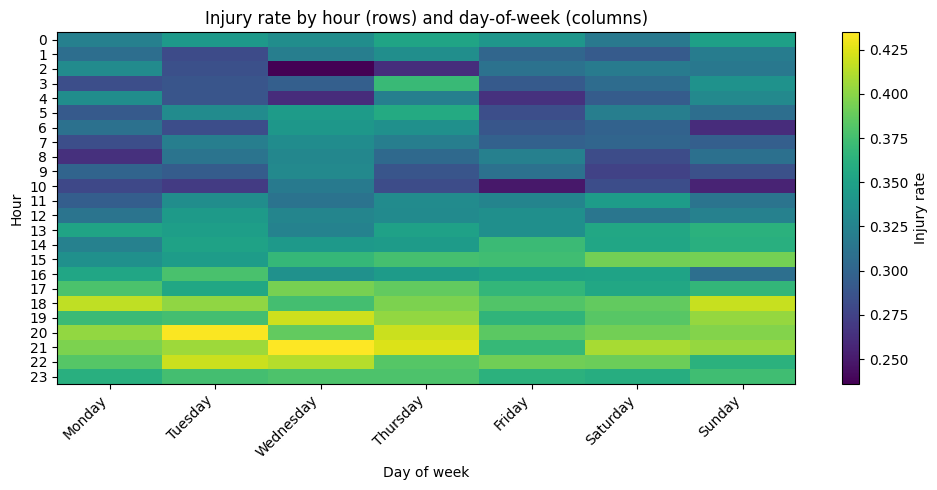

In [33]:

# Injury rate heatmap: hour x day-of-week
if inj in coll.columns:
    tmp = coll.dropna(subset=["accident_hour", "accident_dow"]).copy()
    tmp["has_injury"] = (tmp[inj].fillna(0) >= 1).astype(int)

    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    tmp["accident_dow"] = pd.Categorical(tmp["accident_dow"], categories=dow_order, ordered=True)

    grid = tmp.pivot_table(index="accident_hour", columns="accident_dow", values="has_injury", aggfunc="mean")
    grid = grid.reindex(index=list(range(24)), columns=dow_order)

    plt.figure(figsize=(10, 5))
    plt.imshow(grid.to_numpy(), aspect="auto")
    plt.title("Injury rate by hour (rows) and day-of-week (columns)")
    plt.xlabel("Day of week")
    plt.ylabel("Hour")
    plt.xticks(range(len(dow_order)), dow_order, rotation=45, ha="right")
    plt.yticks(range(24), range(24))
    plt.colorbar(label="Injury rate")
    plt.tight_layout()
    plt.show()

    grid.head()
else:
    "Injury column not found."

### Group comparison with uncertainty: Wilson interval for injury rate

For a group (e.g., borough), a naive interval for a proportion can behave poorly when $p$ is near 0 or 1.
A commonly used alternative is the Wilson interval:

$$
\hat{p}_W = \frac{p + \frac{z^2}{2n}}{1 + \frac{z^2}{n}}, \quad
\text{half} = \frac{z}{1+\frac{z^2}{n}}\sqrt{\frac{p(1-p)}{n} + \frac{z^2}{4n^2}}
$$

We will compute injury-rate-by-borough with 95% Wilson intervals and visualize error bars.

In [34]:

def wilson_interval(k, n, z=1.96):
    if n <= 0:
        return (np.nan, np.nan, np.nan)
    p = k / n
    denom = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z / denom) * math.sqrt((p*(1-p))/n + (z**2)/(4*n**2))
    return (center, max(0.0, center-half), min(1.0, center+half))

if "BOROUGH" in coll.columns and inj in coll.columns:
    g = coll.copy()
    g["has_injury"] = (g[inj].fillna(0) >= 1).astype(int)
    grp = g.groupby(g["BOROUGH"].fillna("Missing"))["has_injury"].agg(["sum","count"]).rename(columns={"sum":"k","count":"n"})
    out = grp.reset_index().rename(columns={"BOROUGH":"group"})
    out[["p_hat","ci_low","ci_high"]] = out.apply(lambda r: pd.Series(wilson_interval(int(r["k"]), int(r["n"]))), axis=1)
    out["p_hat_pct"] = pct(out["p_hat"])
    out["ci_low_pct"] = pct(out["ci_low"])
    out["ci_high_pct"] = pct(out["ci_high"])
    out.sort_values("p_hat", ascending=False).head(12)
else:
    "Required columns not found."

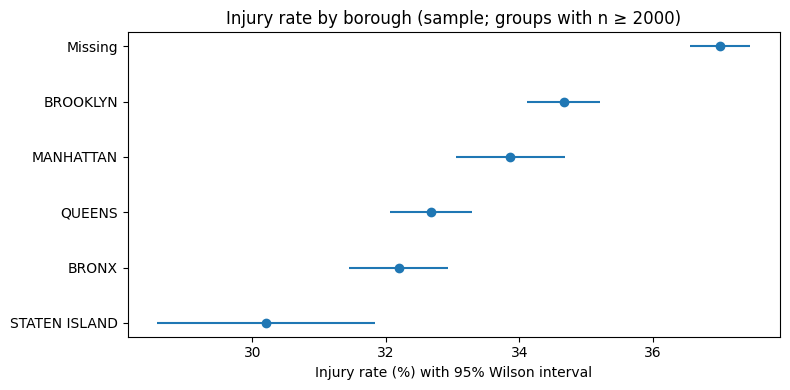

In [35]:

# Error bar plot for top groups by injury rate (only groups with enough samples)
if "BOROUGH" in coll.columns and inj in coll.columns:
    plot_df = out[out["n"] >= 2000].sort_values("p_hat", ascending=False).head(10).copy()
    plot_df = plot_df.sort_values("p_hat")  # nicer horizontal plot

    y = np.arange(len(plot_df))
    x = plot_df["p_hat_pct"].to_numpy()
    xerr = np.vstack([x - plot_df["ci_low_pct"].to_numpy(), plot_df["ci_high_pct"].to_numpy() - x])

    plt.figure(figsize=(8, 4))
    plt.errorbar(x, y, xerr=xerr, fmt="o")
    plt.yticks(y, plot_df["group"])
    plt.xlabel("Injury rate (%) with 95% Wilson interval")
    plt.title("Injury rate by borough (sample; groups with n ≥ 2000)")
    plt.tight_layout()
    plt.show()

    plot_df[["group","n","p_hat_pct","ci_low_pct","ci_high_pct"]]
else:
    "Required columns not found."

### Evidence with context: “Top streets” is not the same as “Most dangerous streets”

Counts are sensitive to exposure. A street with more traffic can have more collisions even if risk per mile is lower.

Still, “top streets by count” can be useful as an operational starting point, *as long as the report labels it correctly*.

In [36]:

street_col = "STREET NAME"
cross_col = "CROSS STREET NAME"

def top_counts(series, n=15):
    return series.fillna("Missing").astype(str).str.strip().replace("", "Missing").value_counts().head(n)

if street_col in coll.columns:
    top_streets = top_counts(coll[street_col], 15)
    df_to_markdown(top_streets.reset_index().rename(columns={"index":"street","STREET NAME":"count"}), title="Top streets by collision count (sample)")
else:
    "Street column not found."

### Top streets by collision count (sample)

| count | count |
| --- | --- |
| Missing | 33793 |
| BELT PARKWAY | 2087 |
| LONG ISLAND EXPRESSWAY | 1154 |
| BROOKLYN QUEENS EXPRESSWAY | 1084 |
| FDR DRIVE | 1047 |
| BROADWAY | 1013 |
| ATLANTIC AVENUE | 959 |
| GRAND CENTRAL PKWY | 891 |
| MAJOR DEEGAN EXPRESSWAY | 853 |
| CROSS ISLAND PARKWAY | 840 |
| CROSS BRONX EXPY | 785 |
| LINDEN BOULEVARD | 706 |
| 3 AVENUE | 672 |
| VAN WYCK EXPWY | 653 |
| BRUCKNER EXPRESSWAY | 519 |

In [37]:

# Compare contributing factors for injury vs no-injury collisions
factor_col = "CONTRIBUTING FACTOR"
if factor_col in coll.columns and inj in coll.columns:
    tmp = coll.copy()
    tmp["has_injury"] = (tmp[inj].fillna(0) >= 1).astype(int)
    tmp[factor_col] = tmp[factor_col].fillna("Missing")

    top = tmp[factor_col].value_counts().head(12).index
    t2 = tmp[tmp[factor_col].isin(top)].groupby(["has_injury", factor_col]).size().unstack(fill_value=0)
    t2_share = t2.div(t2.sum(axis=1), axis=0)
    df_to_markdown(t2_share.reset_index().rename(columns={0:"No injury",1:"Injury"}), title="Factor share by injury involvement (top factors)")
else:
    "Required columns not found."

### Factor share by injury involvement (top factors)

| has_injury | Backing Unsafely | Driver Inattention/Distraction | Failure to Yield Right-of-Way | Following Too Closely | Other Vehicular | Passing Too Closely | Passing or Lane Usage Improper | Traffic Control Disregarded | Turning Improperly | Unsafe Lane Changing | Unsafe Speed | Unspecified |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 0.04530780055737976 | 0.2597334510637124 | 0.04631494715929472 | 0.069217184956265 | 0.033387599679920534 | 0.06052537181645098 | 0.05783504870174664 | 0.021039706409867277 | 0.02535801992218758 | 0.025730526199608177 | 0.03476725255925609 | 0.32078309097431085 |
| 1.0 | 0.019162911894033983 | 0.301205146300418 | 0.1396775419358341 | 0.0867759622170349 | 0.027278649367569623 | 0.012322892351121004 | 0.036398675424786926 | 0.05333586667390478 | 0.02426578361652462 | 0.021035774387926823 | 0.05328158080451659 | 0.22525921502632865 |

---

## 16) Deepening the locations analysis: canonicalization pipeline

For location/entity datasets, “EDA reporting” often means documenting the steps needed to make the dataset usable.

A practical canonicalization pipeline:

1. **Standardize text fields** (trim, lower, normalize punctuation)
2. **Geospatial sanity checks** (missingness, outliers, duplicate coordinates)
3. **Deduplicate entities** (string similarity + spatial proximity)
4. **Standardize categories** (taxonomy mapping + versioning)
5. **Publish a reference table** with stable keys

Below are examples for steps 1–4.

In [38]:

# Standardize text fields for analysis
def normalize_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    s = " ".join(s.split())
    return s

ff2 = ff.copy()

for col in ["name", "city", "province", "country", "categories"]:
    if col in ff2.columns:
        ff2[col + "_n"] = ff2[col].apply(normalize_text)

ff2[[c for c in ff2.columns if c.endswith("_n")]].head()

,name_n,city_n,province_n,country_n,categories_n
0,sonic drive in,thibodaux,la,us,american restaurant and fast food restaurant
1,sonic drive in,thibodaux,la,us,fast food restaurants
2,taco bell,pigeon forge,tn,us,fast food restaurant
3,arby's,pigeon forge,tn,us,fast food
4,steak 'n shake,morrow,ga,us,fast food restaurant


In [39]:

# Extract URL domains for reporting
import urllib.parse as ul

def domain_from_url(u):
    if not isinstance(u, str):
        return ""
    u = u.strip()
    if not u:
        return ""
    if "://" not in u:
        u = "http://" + u
    try:
        return ul.urlsplit(u).netloc.lower()
    except Exception:
        return ""

if "websites" in ff2.columns:
    domains = ff2["websites"].fillna("").astype(str).apply(lambda s: [domain_from_url(x) for x in split_and_normalize_urls(s)])
    dom_counts = pd.Series([d for lst in domains for d in lst if d]).value_counts().head(20)
    df_to_markdown(dom_counts.reset_index().rename(columns={"index":"domain", 0:"count"}), title="Top website domains (sample)")
else:
    "Column websites not found."

### Top website domains (sample)

| domain | count |
| --- | --- |
| www.mcdonalds.com | 1903 |
| mcdonalds.com | 1837 |
| locations.tacobell.com | 1036 |
| www.tacobell.com | 924 |
| www.bk.com | 768 |
| www.subway.com | 726 |
| locations.arbys.com | 704 |
| www.dominos.com | 649 |
| www.wendys.com | 624 |
| api.citygridmedia.com | 616 |
| www.arbys.com | 609 |
| subway.com | 492 |
| www.jackinthebox.com | 447 |
| locations.bk.com | 359 |
| www.chick-fil-a.com | 316 |
| tacobell.com | 299 |
| www.pizzahut.com | 266 |
| wendys.com | 223 |
| bk.com | 223 |
| arbys.com | 222 |

In [40]:

# Example: candidate duplicates using name similarity within the same rounded coordinate cell
import difflib

def name_similarity(a, b):
    return difflib.SequenceMatcher(None, a, b).ratio()

if {"name_n","lat_r","lon_r"}.issubset(ff_key.columns):
    # take one high-duplicate cluster (if it exists)
    candidates = dup_counts[dup_counts >= 3]
    if len(candidates) > 0:
        key = candidates.index[0]
        cluster = ff_key[(ff_key["name_n"] == key[0]) & (ff_key["lat_r"] == key[1]) & (ff_key["lon_r"] == key[2])]
        cluster[["name","address","city","province","latitude","longitude"]].head(10)
    else:
        "No clusters with size ≥ 3 found in the sample."
else:
    "ff_key not computed; run the duplicate key cell above."

---

## 17) A minimal report generator (structured findings)

Teams scale reporting by standardizing the “finding object” and rendering it.

We will define a small `Finding` structure and render it to Markdown.

Each finding includes:
- observation (quantified)
- evidence (what to look at)
- implication (why it matters)
- recommendation (next action)
- confidence (High/Medium/Low)

This is intentionally lightweight; it can be extended into a formal template later.

In [41]:

from dataclasses import dataclass
from typing import List, Optional

@dataclass
class Finding:
    title: str
    observation: str
    evidence: str
    implication: str
    recommendation: str
    confidence: str = "Medium"
    owner: Optional[str] = None

def render_findings(findings: List[Finding], heading="Key Findings"):
    lines = [f"# {heading}", ""]
    for i, fnd in enumerate(findings, 1):
        lines.append(f"## {i}. {fnd.title}")
        lines.append(f"- **Observation:** {fnd.observation}")
        lines.append(f"- **Evidence:** {fnd.evidence}")
        lines.append(f"- **Implication:** {fnd.implication}")
        lines.append(f"- **Recommendation:** {fnd.recommendation}")
        lines.append(f"- **Confidence:** {fnd.confidence}")
        if fnd.owner:
            lines.append(f"- **Owner:** {fnd.owner}")
        lines.append("")
    return "\n".join(lines)

# Build example findings from computed metrics (edit these for your final report)
example_findings = []

if inj in coll.columns and "accident_hour" in coll.columns:
    hr = coll["accident_hour"].value_counts().sort_index()
    peak_hour = int(hr.idxmax())
    example_findings.append(
        Finding(
            title="Collisions concentrate in specific hours",
            observation=f"Highest collision volume occurs around hour {peak_hour} in this sample.",
            evidence="Hour-of-day bar chart; injury-rate heatmap (Section 15).",
            implication="Operational interventions can be targeted to peak windows.",
            recommendation="Create an injury-weighted peak-hour list and validate intervention impact via pre/post comparison.",
            confidence="Medium",
            owner="Analytics"
        )
    )

if "BOROUGH" in coll.columns and inj in coll.columns:
    # Use previously computed `out` if available; otherwise compute quickly
    try:
        top_group = out.sort_values("p_hat", ascending=False).iloc[0]["group"]
    except Exception:
        top_group = "Unknown"
    example_findings.append(
        Finding(
            title="Borough comparisons require missingness-aware reporting",
            observation="Geography fields have missingness; borough-level rates vary across groups in the sample.",
            evidence="Missingness table (Section 3) + borough injury-rate plot with intervals (Section 15).",
            implication="Naive borough ranking may be biased if missingness is systematic.",
            recommendation="Include an 'Unknown' group, test missingness mechanisms, and publish borough comparisons with uncertainty bars.",
            confidence="Low",
            owner="Analytics / Data Engineering"
        )
    )

if "websites" in ff.columns:
    example_findings.append(
        Finding(
            title="Location dataset needs canonicalization for reliable analytics",
            observation="Raw rows include duplicates and heterogeneous fields (categories/websites).",
            evidence="Duplicate key counts; domain distribution; taxonomy mapping coverage (Section 16).",
            implication="Unclean entities lead to inflated counts and unstable trends.",
            recommendation="Publish a canonical entity table with stable keys, dedupe rules, and versioned taxonomy mapping.",
            confidence="Medium",
            owner="Data Engineering"
        )
    )

display(Markdown(render_findings(example_findings, heading="Example Findings (Draft)")))

# Example Findings (Draft)

## 1. Collisions concentrate in specific hours
- **Observation:** Highest collision volume occurs around hour 16 in this sample.
- **Evidence:** Hour-of-day bar chart; injury-rate heatmap (Section 15).
- **Implication:** Operational interventions can be targeted to peak windows.
- **Recommendation:** Create an injury-weighted peak-hour list and validate intervention impact via pre/post comparison.
- **Confidence:** Medium
- **Owner:** Analytics

## 2. Borough comparisons require missingness-aware reporting
- **Observation:** Geography fields have missingness; borough-level rates vary across groups in the sample.
- **Evidence:** Missingness table (Section 3) + borough injury-rate plot with intervals (Section 15).
- **Implication:** Naive borough ranking may be biased if missingness is systematic.
- **Recommendation:** Include an 'Unknown' group, test missingness mechanisms, and publish borough comparisons with uncertainty bars.
- **Confidence:** Low
- **Owner:** Analytics / Data Engineering

## 3. Location dataset needs canonicalization for reliable analytics
- **Observation:** Raw rows include duplicates and heterogeneous fields (categories/websites).
- **Evidence:** Duplicate key counts; domain distribution; taxonomy mapping coverage (Section 16).
- **Implication:** Unclean entities lead to inflated counts and unstable trends.
- **Recommendation:** Publish a canonical entity table with stable keys, dedupe rules, and versioned taxonomy mapping.
- **Confidence:** Medium
- **Owner:** Data Engineering


---

## 18) Exercises (extended)

1. **Rewrite a finding**: Take one chart above and write a full block (Claim → Evidence → Qualification → Decision).
2. **Add a validation plan**: For the collision peak-hour intervention, propose:
   - a metric,
   - a baseline period,
   - an evaluation design.
3. **Severity buckets**: Extend severity into 4 levels:
   - 0 injuries,
   - 1 injury,
   - 2–3 injuries,
   - 4+ injuries,
   and report the monthly share for each level.
4. **Entity resolution**: For fast food, propose a canonical key and a rule for merging:
   - exact duplicates,
   - near duplicates (same rounded coords, similar names),
   - uncertain cases (send to human review).
5. **Governance**: Define how you will version taxonomy mappings and how you will detect category drift.

---

## 19) A full EDA report skeleton you can copy into your own projects

Below is a practical structure that works for many ML projects. You can keep it as a Markdown section in the notebook, or export it into a standalone report.

### 19.1 Executive summary (5–10 bullets)

- **Objective:** What decision does this support?
- **Scope:** Dataset(s), time range, filters, sample sizes.
- **Top findings (3–5):** Each in the form Observation → Implication → Recommendation.
- **Key risks:** Data quality risks, bias risks, leakage risks.
- **Decision asks:** What choices need stakeholder input?

**Example bullets (illustrative):**
- “In the sample, injury involvement is rare but not negligible; the distribution is heavy-tailed (P99 ≫ median). We recommend reporting severity buckets, not only means.”
- “Geographic fields have meaningful missingness; borough comparisons must include an ‘Unknown’ group and a sensitivity analysis.”

### 19.2 Context and business framing

- Who is the customer?
- What is the success metric (and why)?
- What decisions are on the table (do nothing, intervention A, intervention B)?
- What constraints exist (budget, timeline, policy)?

### 19.3 Data description

- Table(s) and source(s)
- Primary keys and grain (event-level vs entity-level)
- Field definitions (especially targets and timestamps)
- Data latency and update cadence

### 19.4 Data quality and governance

Include the “boring but critical” section:

- Missingness: top missing fields and why it matters
- Duplicates: row-level and entity-level
- Validity rules: e.g., coordinates in valid ranges; dates parseable
- Provenance: which upstream systems produced the fields
- PII/privacy notes (if relevant)

### 19.5 Findings (with evidence)

For each finding, require:
- a table/plot,
- an interpretation,
- a caveat,
- and a recommended next step.

### 19.6 Risks and assumptions

- Assumption register (testable statements)
- Risk register (severity, likelihood, mitigation)
- Known limitations that affect conclusions

### 19.7 Recommendations and roadmap

- Action plan with owners, effort, and expected impact
- Validation plan for each action
- Timeline (even a rough one) and dependencies

### 19.8 Appendix

- Additional plots/tables
- Data dictionary
- Reproducibility notes (random seeds, versions, environment)

---

## 20) A small “library” of report-ready language

Stakeholders value consistency. The goal is not to sound academic; it is to make claims falsifiable.

### 20.1 Language for uncertainty (pick one)

- **High confidence:** “We consistently observe … across slices and time windows.”
- **Medium confidence:** “We observe … in the current sample; results may change under different filters.”
- **Low confidence:** “Evidence is suggestive but incomplete due to missingness or small counts.”

### 20.2 Language for limitations

- “Counts do not equal risk rates; exposure denominators are not available in this dataset.”
- “Geographic coverage is incomplete; location comparisons may be biased.”
- “Free-text categories require governance decisions; mapping may change over time.”

### 20.3 Language for recommendations

- “We recommend … as a v1 baseline, and propose validation via …”
- “If this assumption fails, we will …”
- “To operationalize this, the owner team will … by [date/window].”

### 20.4 Five fully written example findings (templates)

**Finding 1 (time concentration):**
- Observation: “Collision volume peaks at specific hours; the peak hour in this sample is hour X.”
- Evidence: “Hour-of-day chart; injury-rate heatmap.”
- Implication: “Time-bound interventions can target peak windows for higher leverage.”
- Recommendation: “Pilot interventions for the top hours; evaluate with severity-weighted outcomes.”

**Finding 2 (geographic missingness):**
- Observation: “`BOROUGH` is missing in Y% of records.”
- Evidence: “Missingness table + borough plots with ‘Unknown’ group.”
- Implication: “Rankings may be biased if missingness correlates with injury severity.”
- Recommendation: “Analyze missingness mechanisms and publish sensitivity analyses.”

**Finding 3 (heavy tails):**
- Observation: “Injuries are heavy-tailed: P99 is much larger than the median.”
- Evidence: “Descriptive stats table; severity bucket distribution.”
- Implication: “Mean-based summaries understate rare high-impact events.”
- Recommendation: “Report tail metrics and bucketed severity; design interventions around tail outcomes.”

**Finding 4 (entity dedup):**
- Observation: “Potential duplicates exist under name normalization + rounded coordinates.”
- Evidence: “Duplicate-key table; example cluster inspection.”
- Implication: “Counts and coverage are inflated; category distributions may be distorted.”
- Recommendation: “Publish a canonical location table with stable keys and dedupe rules; audit ambiguous clusters.”

**Finding 5 (taxonomy governance):**
- Observation: “Category strings are heterogeneous; taxonomy mapping yields partial coverage.”
- Evidence: “Coverage metric; unmapped top strings.”
- Implication: “Trend comparisons are unstable without a consistent category layer.”
- Recommendation: “Version a taxonomy mapping; monitor drift and review periodically.”

You should replace X/Y with numbers from your outputs.

---

## 21) Exporting your report artifacts

In many teams, the notebook is the working environment, but the report is delivered as:

- Markdown (for GitHub / internal docs),
- HTML (for sharing with non-technical readers),
- or a dashboard (for ongoing monitoring).

Below we export a simple Markdown draft using the findings and registers we created.

In [42]:
# Export a simple Markdown report draft (no optional dependencies)
import os
from datetime import datetime

report_lines = []
report_lines.append("# EDA Report Draft — Chapter 3 Lesson 10")
report_lines.append("")
report_lines.append(f"- Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}")
report_lines.append(f"- Datasets: {DATASET_COLLISIONS}, {DATASET_FASTFOOD}")
report_lines.append("")
report_lines.append("## Executive Summaries")
report_lines.append("")
report_lines.append("### NYC Collisions (sample)")
report_lines.append("(See notebook outputs in Sections 4, 5, 15.)")
report_lines.append("")
report_lines.append("### Fast Food Restaurants (sample)")
report_lines.append("(See notebook outputs in Sections 6, 16.)")
report_lines.append("")
report_lines.append("## Key Findings (draft)")
report_lines.append("")
report_lines.append(render_findings(example_findings, heading="Key Findings (Draft)"))
report_lines.append("")
report_lines.append("## Action plan")
report_lines.append(df_to_markdown_str(actions_scored, max_rows=200))
report_lines.append("")
report_lines.append("## Assumptions")
report_lines.append(df_to_markdown_str(assumptions, max_rows=200))
report_lines.append("")

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "eda_report_draft.md")

with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

out_path


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_2848\1817855401.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  report_lines.append(f"- Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}")


'outputs\\eda_report_draft.md'

Open the generated `outputs/eda_report_draft.md` file in your repository to view the draft report.

If you want a more formal report, expand the generator to:
- embed key tables directly,
- add links to saved plots,
- and include a version header (data snapshot date, code version, author).